In [1]:
import numpy as np
import pandas as pd
import math 
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.cluster import KMeans
import sklearn.cluster as cluster
import csv
from scipy.spatial.distance import euclidean
from scipy.spatial.distance import cdist

In [2]:
all_data = pd.read_csv('all_data.csv')
# Replace NaN values with 0 in the 'tot_solar_mwh' column
all_data["tot_solar_mwh"] = all_data["tot_solar_mwh"].fillna(0)
n_days =  365
all_data.head()

,Date,Hr_End,RT_Demand,tot_solar_mwh,tot_wind_mwh,net_demand_mwh
0,1-Jan-22,1,117267.1781,0.0,5896.511745,111370.6664
1,1-Jan-22,2,118780.4624,0.0,5792.834164,112987.6283
2,1-Jan-22,3,122307.0229,0.0,5876.165118,116430.8578
3,1-Jan-22,4,127341.1629,0.0,5796.031289,121545.1316
4,1-Jan-22,5,131696.0562,0.0,6006.146647,125689.9095


In [3]:
# Read data
load = np.reshape(np.array(all_data['RT_Demand']), (n_days, 24))
wind = np.reshape(np.array(all_data['tot_wind_mwh']), (n_days, 24))
solar = np.reshape(np.array(all_data['tot_solar_mwh']), (n_days, 24))
net_load = np.reshape(np.array(all_data['net_demand_mwh']), (n_days, 24))

In [4]:
# Data normalization
norm_load = (load-np.min(load))/(np.max(load)-np.min(load))
norm_wind = (wind-np.min(wind))/(np.max(wind)-np.min(wind))
norm_solar = (solar-np.min(solar))/(np.max(solar)-np.min(solar))
norm_net_load = (net_load-np.min(net_load))/(np.max(net_load)-np.min(net_load))

# Find five days of interest (extreme scenarios by definition)

In [5]:
def find_extreme(load,wind,solar):
    extreme_load = []
    extreme_wind = []
    extreme_solar = []
    extreme_days = []
    
    # calculate maximum load in each day
    load_max = np.max(load, axis=1)
    # calculate average power of wind and solar in each day
    wind_average = np.mean(wind, axis=1)
    solar_average = np.mean(solar, axis=1)
    # calculate ramping of wind in each day
    wind_ramping = np.diff(wind, axis=1)
    # calculate variance of solar in each day
    solar_variance = np.var(solar, axis=1)
    
    # Extreme scenario 1: maximum value of load
    max_load = np.amax(load_max)
    index_max_load = np.where(load_max == max_load)
    extreme_days.append(index_max_load[0][0])
    extreme_load.append(load[index_max_load[0][0],:])
    extreme_wind.append(wind[index_max_load[0][0],:])
    extreme_solar.append(solar[index_max_load[0][0],:])
        
    # Extreme scenario 2: minimum average power in wind power
    min_wind = np.amin(wind_average)
    index_min_wind = np.where(wind_average == min_wind)
    extreme_days.append(index_min_wind[0][0])
    extreme_load.append(load[index_min_wind[0][0],:])
    extreme_wind.append(wind[index_min_wind[0][0],:])
    extreme_solar.append(solar[index_min_wind[0][0],:])
    
    # Extreme scenario 3: maximum ramping up/down in wind power
    max_ramping = np.amax(abs(wind_ramping))
    index_max_ramping = np.where(abs(wind_ramping) == max_ramping)
    extreme_days.append(index_max_ramping[1][0])
    extreme_load.append(load[index_max_ramping[1][0],:])
    extreme_wind.append(wind[index_max_ramping[1][0],:])
    extreme_solar.append(solar[index_max_ramping[1][0],:])
    # Note: If index_max_ramping only contains one value, change [index_max_ramping[1][0],:] to [index_max_ramping[0][0],:]
    
    # Extreme scenario 4: minimum average power in solar power
    min_solar = np.amin(solar_average)
    index_min_solar = np.where(solar_average == min_solar)
    extreme_days.append(index_min_solar[0][0])
    extreme_load.append(load[index_min_solar[0][0],:])
    extreme_wind.append(wind[index_min_solar[0][0],:])
    extreme_solar.append(solar[index_min_solar[0][0],:])
    
    # Extreme scenario 5: maximum variance in solar power
    max_variance = np.amax(solar_variance)
    index_max_variance = np.where(solar_variance  == max_variance)
    extreme_days.append(index_max_variance[0][0])
    extreme_load.append(load[index_max_variance[0][0],:])
    extreme_wind.append(wind[index_max_variance[0][0],:])
    extreme_solar.append(solar[index_max_variance[0][0],:])
    
    return extreme_days, extreme_load, extreme_wind, extreme_solar

In [6]:
extreme_days, extreme_load, extreme_wind, extreme_solar = find_extreme(norm_load,norm_wind,norm_solar)

In [7]:
extreme_days

[235, 246, 18, 364, 109]

In [8]:
with open('extreme_scenarios_load.csv', 'w', newline='') as f:
    write = csv.writer(f)
    write.writerows(extreme_load)
with open('extreme_scenarios_wind.csv', 'w', newline='') as f:
    write = csv.writer(f)
    write.writerows(extreme_wind)
with open('extreme_scenarios_solar.csv', 'w', newline='') as f:
    write = csv.writer(f)
    write.writerows(extreme_solar)

In [9]:
extreme_load

[array([0.33138532, 0.35945137, 0.42534969, 0.47698647, 0.54806793,
        0.63426613, 0.718722  , 0.78950793, 0.85392378, 0.91153857,
        0.94546874, 0.97086191, 0.99188886, 1.        , 0.98595386,
        0.94832678, 0.90838122, 0.82639696, 0.71668618, 0.60487038,
        0.50552063, 0.43056566, 0.37882569, 0.34500655]),
 array([0.16458388, 0.16835004, 0.18739445, 0.21026784, 0.25178881,
        0.28943329, 0.32096193, 0.34103503, 0.34826389, 0.34767662,
        0.33928255, 0.32792506, 0.32027494, 0.31348399, 0.30556862,
        0.30642919, 0.3023253 , 0.27393246, 0.23014922, 0.18099661,
        0.13310851, 0.0945823 , 0.06771905, 0.04960896]),
 array([0.14121116, 0.15725601, 0.20637742, 0.29416782, 0.35685142,
        0.37919159, 0.38765151, 0.38463643, 0.37738361, 0.36789424,
        0.361854  , 0.35624596, 0.36297367, 0.38603444, 0.43514181,
        0.46865735, 0.46823748, 0.44848576, 0.41072836, 0.35507388,
        0.29951671, 0.25796198, 0.23384086, 0.22155285]),
 array([0.

In [10]:
print(np.array(extreme_load).shape)

(5, 24)


Text(0.5, 1.0, 'Load curves in five days of interest')

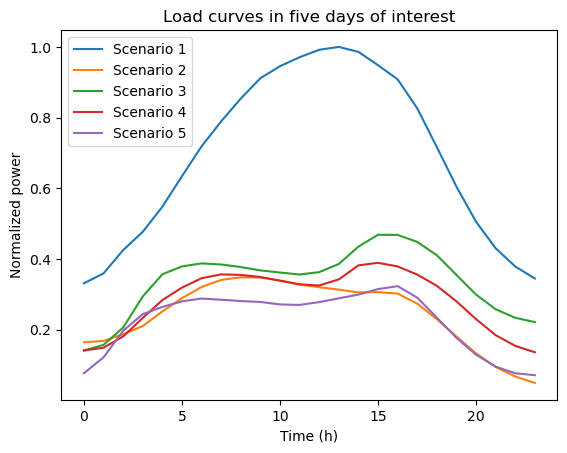

In [11]:
extreme_load = np.array(extreme_load)
label_list =['Scenario 1', 'Scenario 2', 'Scenario 3', 'Scenario 4', 'Scenario 5']
for i in range(5):
    plt.plot(extreme_load[i,:], label=label_list[i])
plt.legend()
plt.xlabel('Time (h)')
plt.ylabel('Normalized power')
plt.title('Load curves in five days of interest')

Text(0.5, 1.0, 'Wind power curves in five days of interest')

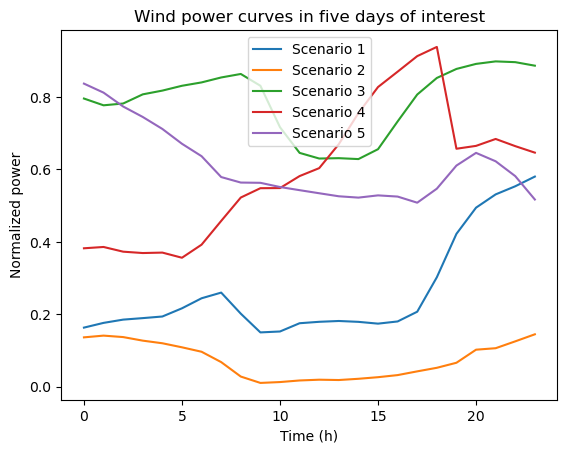

In [12]:
extreme_wind = np.array(extreme_wind)
label_list =['Scenario 1', 'Scenario 2', 'Scenario 3', 'Scenario 4', 'Scenario 5']
for i in range(5):
    plt.plot(extreme_wind[i,:], label=label_list[i])
plt.legend()
plt.xlabel('Time (h)')
plt.ylabel('Normalized power')
plt.title('Wind power curves in five days of interest')

Text(0.5, 1.0, 'Solar power curves in five days of interest')

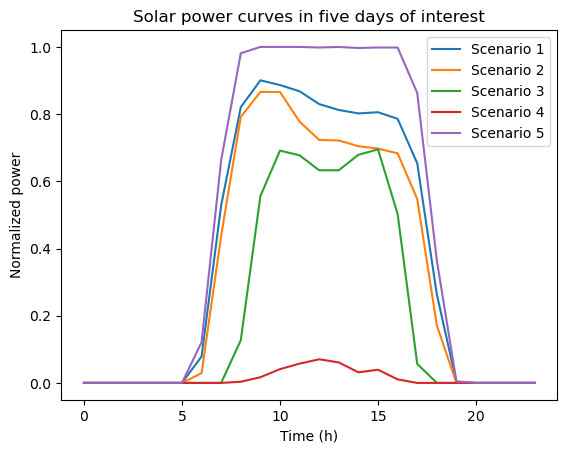

In [13]:
extreme_solar = np.array(extreme_solar)
label_list =['Scenario 1', 'Scenario 2', 'Scenario 3', 'Scenario 4', 'Scenario 5']
for i in range(5):
    plt.plot(extreme_solar[i,:], label=label_list[i])
plt.legend()
plt.xlabel('Time (h)')
plt.ylabel('Normalized power')
plt.title('Solar power curves in five days of interest')

# Find five other medoids using k-medoids clustering

In [14]:
def k_medoids_with_fixed_medoids(X, k, fixed_medoids, max_iter=100, tol=1e-5):
    m, n = X.shape
    # Ensure fixed_medoids are part of the dataset
    fixed_medoids_idx = [np.where(np.all(X == medoid, axis=1))[0][0] for medoid in fixed_medoids]
    # Initialize medoids with fixed medoids and add random ones
    remaining_idx = np.setdiff1d(range(m), fixed_medoids_idx)
    random_medoids_idx = np.random.choice(remaining_idx, k-len(fixed_medoids_idx), replace=False)
    medoids_idx = np.concatenate((fixed_medoids_idx, random_medoids_idx))
    medoids = X[medoids_idx, :]
    labels = np.zeros(m)
    for _ in range(max_iter):
        # Compute distances from data points to medoids
        distances = cdist(X, medoids, 'euclidean')
        # Assign each data point to the closest medoid
        labels = np.argmin(distances, axis=1)
        old_medoids = medoids.copy()
        # Update only the non-fixed medoids
        for i in range(len(fixed_medoids_idx), k):
            cluster_idx = np.where(labels == i)[0]
            if cluster_idx.size > 0:
                cluster_distances = cdist(X[cluster_idx, :], X[cluster_idx, :], 'euclidean')
                costs = cluster_distances.sum(axis=1)
                medoids_idx[i] = cluster_idx[np.argmin(costs)]
        medoids = X[medoids_idx, :]
        # Check for convergence
        if np.all(old_medoids == medoids):
            break
    return labels, medoids, medoids_idx

In [15]:
# Total number of clusters
k = 10

# Forced inclusion of selected days of interest as fixed medoids
extreme_scenarios = np.hstack((extreme_load, extreme_wind, extreme_solar))
fixed_medoids = extreme_scenarios

# Run k-medoids clustering
combined_data = np.hstack((norm_load, norm_wind, norm_solar))
labels, medoids, medoids_idx = k_medoids_with_fixed_medoids(combined_data, k, fixed_medoids)

In [16]:
# index of ten representative days
medoids_idx

array([235, 246,  18, 364, 109,  49,  74, 229, 325, 322])

In [17]:
print(medoids.shape)

(10, 72)


Text(0.5, 1.0, 'Load curves in ten medoids')

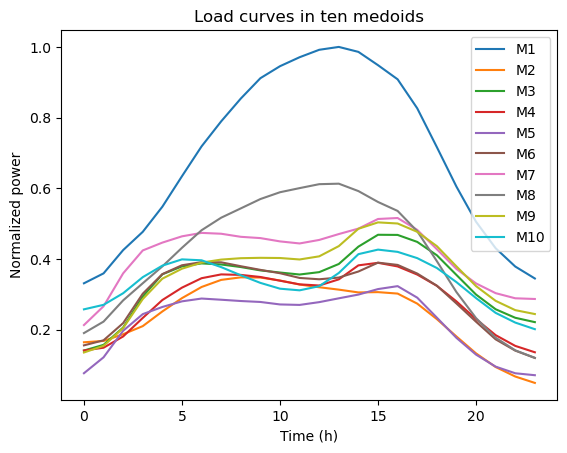

In [18]:
label_list =['M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9', 'M10']
for i in range(10):
    plt.plot(medoids[i,0:24], label=label_list[i])
plt.legend()
plt.xlabel('Time (h)')
plt.ylabel('Normalized power')
plt.title('Load curves in ten medoids')

Text(0.5, 1.0, 'Wind power curves in ten medoids')

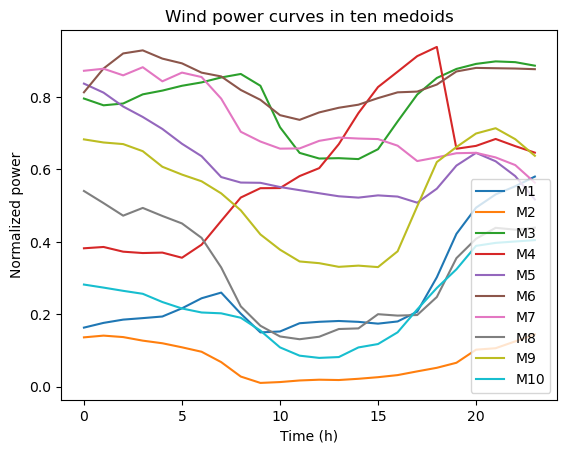

In [19]:
label_list =['M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9', 'M10']
for i in range(10):
    plt.plot(medoids[i,24:48], label=label_list[i])
plt.legend()
plt.xlabel('Time (h)')
plt.ylabel('Normalized power')
plt.title('Wind power curves in ten medoids')

Text(0.5, 1.0, 'Solar power curves in ten medoids')

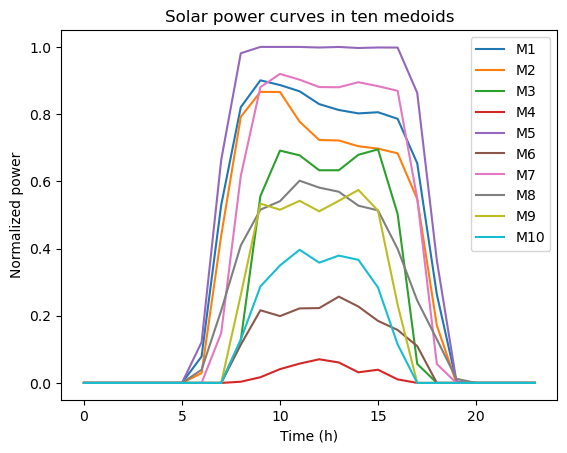

In [20]:
label_list =['M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9', 'M10']
for i in range(10):
    plt.plot(medoids[i,48:72], label=label_list[i])
plt.legend()
plt.xlabel('Time (h)')
plt.ylabel('Normalized power')
plt.title('Solar power curves in ten medoids')

In [21]:
cluster_size = []
for cluster_idx in range(k): 
    index_num = np.argwhere(labels == cluster_idx)
    cluster_size.append(len(index_num)) # Find the size of each cluster
weight = np.array(cluster_size)/365

In [22]:
print(cluster_size)

[30, 25, 34, 15, 15, 50, 16, 71, 76, 33]


In [23]:
with open('ten_representative_days_load.csv', 'w', newline='') as f:
    write = csv.writer(f)
    write.writerows(medoids[:,0:24])
with open('ten_representative_days_wind.csv', 'w', newline='') as f:
    write = csv.writer(f)
    write.writerows(medoids[:,24:48])
with open('ten_representative_days_solar.csv', 'w', newline='') as f:
    write = csv.writer(f)
    write.writerows(medoids[:,48:72])
with open('weights_of_scenarios.csv', 'w', newline='') as f:
    write = csv.writer(f)
    for val in weight:
        write.writerow([val])